In [2]:
# to import from parent directory
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utils import get_lags, remove_nan
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from scipy.spatial.distance import pdist

In [4]:
full = pd.read_csv('../normalised_growth.csv', index_col=0, header=[0] ,parse_dates=True)
full.head()

,CPIAUCSL,FEDFUNDS,HOUST,INDPRO,INTDSRUSM193N,ISRATIO,M2SL,MTSDS133FMS,PAYEMS,PCE,...,CIVPART,GS20,GS3,IRLTLT01USM156N,M1SL,MCOILWTICO,PPIACO,TCU,TOTALSA,PMI
1914-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.635906,NaN,NaN,NaN
1914-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.543396,NaN,NaN,NaN
1914-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.638258,NaN,NaN,NaN
1914-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.638258,NaN,NaN,NaN
1914-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.640650,NaN,NaN,NaN


In [5]:
# start from 1960
full.drop(columns=['A191RL1Q225SBEA'], inplace=True)
full = full.loc["1960-01-01":]
full = remove_nan(full)
print(full.shape)

INTDSRUSM193N
ISRATIO
MTSDS133FMS
T10Y2YM
USSLIND
GFDEGDQ188S
GS20
MCOILWTICO
TCU
TOTALSA
(709, 21)


In [6]:
length = len(full)
val_start = round(length * 0.8)
test_start = round(length * 0.9)    

In [7]:
core_series = ["CPIAUCSL", "A191RO1Q156NBEA", "UNRATE"]

train = full.iloc[:val_start-1]
validation = full.iloc[val_start:test_start-1]
test = full.iloc[test_start:]

print(train.shape)

(566, 21)


In [8]:
def get_median(X):
    dists = pdist(X, 'euclidean')
    dists = np.square(dists)
    return np.median(dists)


In [9]:
kernels = ["polynomial", "rbf"]
alphas = np.logspace(-6, 6, 13)
mses = {}

for lags in range(1, 15):

    X = get_lags(train, lags=lags)
    X = X[lags:]
    y = train[core_series][lags:]
    
    for kernel in kernels:
        for alpha in alphas:
            if kernel == 'rbf':
                model = KernelRidge(kernel=kernel, alpha=alpha, gamma=1/get_median(X))
            else:
                model = KernelRidge(kernel=kernel, alpha=alpha)
            model.fit(X, y)
            y_pred = model.predict(get_lags(validation, lags)[lags:])
            loss = mean_squared_error(y_pred, validation[core_series][lags:])
            mses["%d-%s-%f" % (lags, kernel, alpha)] = loss
                


In [10]:
# just checking the shapes are correct for the loss
print(y_pred.shape)
print(validation[core_series][lags:].shape)

(56, 3)
(56, 3)


In [11]:
# best one

lowest = 10000000

for k, v in mses.items():
    if v < lowest:
        lowest = v
        lowest_key = k
        
print(lowest_key, lowest)

1-polynomial-1.000000 0.1953631608831338


In [12]:
polynomial = []
rbf = []

for k, v in mses.items():
    if k.split("-")[1] == "polynomial" and k.split("-")[2] == "0.100000":
        polynomial.append(v)
    if k.split("-")[1] == "rbf" and k.split("-")[2] == "0.100000":
        rbf.append(v)
        

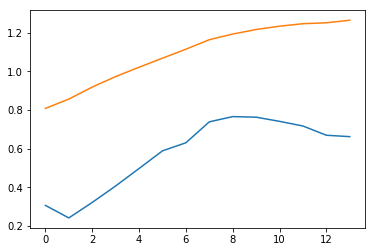

In [13]:
plt.plot(polynomial)
plt.plot(rbf)

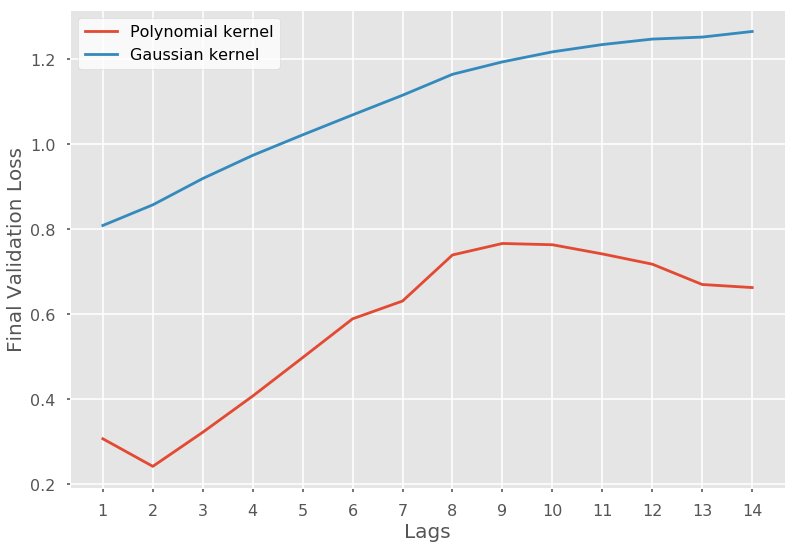

In [14]:
from matplotlib import style

style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')

# plt.figure(figsize=(15,10))

plt.plot([i for i in range(1, len(polynomial) + 1)], polynomial)
plt.plot([i for i in range(1, len(rbf) + 1)], rbf)

plt.xticks([i for i in range(1, 15)])

plt.legend(("Polynomial kernel", "Gaussian kernel"), facecolor="white")
plt.xlabel("Lags", fontsize=20)
plt.ylabel("Final Validation Loss", fontsize=20)
plt.savefig('../Figs/lags_kernel_extended.png', bbox_inches='tight')

# Forecasts

In [9]:
from math import sqrt
from utils import save_obj

In [20]:
lags = 1

X = get_lags(train, lags=lags)
X = X[lags:]
y = train[core_series][lags:]

In [22]:
model = KernelRidge(kernel='polynomial', alpha=1)
model.fit(X, y)

y_pred = model.predict(get_lags(test, lags)[lags:])
loss = mean_squared_error(y_pred, test[core_series][lags:])

In [23]:
sqrt(loss)

0.22876340173492818

In [24]:
save_obj(y_pred, "../Forecasts Extended/KR")

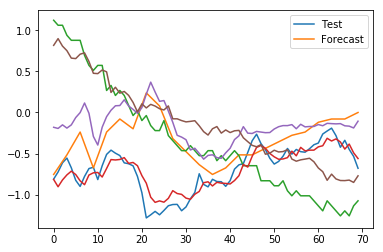

In [31]:
plt.plot(test[core_series].values[lags:,:])
plt.plot(y_pred[:,:])
plt.legend(("Test", "Forecast"), facecolor="white")

In [17]:
test.shape

(71, 21)